In [1]:
# Read mnist dataset
import sys, numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
images, labels = (x_train[0:1000].reshape(1000,28*28) / 255, y_train[0:1000])

In [3]:
images[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<function matplotlib.pyplot.show(*args, **kw)>

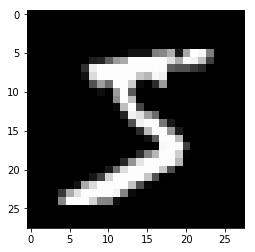

In [5]:
import matplotlib.pyplot as plt
plt.gray()
plt.imshow(images[0].reshape(28,28))
plt.show

In [8]:
for i,l in enumerate(labels[:5]):
    print(i, l)

0 5
1 0
2 4
3 1
4 9


In [9]:
one_hot_labels = np.zeros((len(labels),10))
for i,l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

In [10]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = np.zeros((len(y_test),10))
for i,l in enumerate(y_test):
    test_labels[i][l] = 1
test_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
# Multiple hidden nodes
def relu(x):
    return (x>0) * x #returns 1 if x>0 otherwise 0

def reluderiv(output):
    return (output>0) * 1 # returns 1 if output > 0 otherwise returns 0

class NN():
    def __init__(self, inputs, hidden_layers, outputs, lr, verbose=False, 
                 weights_init_multiplier=0.2, 
                 weights_init_add=-0.1):
        self.weights = []
        self.hidden_layers = hidden_layers
        self.weights_init_multiplier = weights_init_multiplier
        self.weights_init_add = weights_init_add
        previous_nodes = inputs     
        for i in range(len(self.hidden_layers)):
            self.weights.append(self.get_weights(previous_nodes, self.hidden_layers[i]))
            previous_nodes =  hidden_layers[i]
        self.weights.append(self.get_weights(previous_nodes, outputs))
        
        self.lr = lr
        self.verbose = verbose
    
    def get_weights(self, inputs, outputs):
        # np.random.random returns random numbers in range 0..1
        # if you use weights_init_multiplier = 0.2 and weights_init_add = -0.1 
        # then you get numbers in range -0.1..0.1
        return self.weights_init_multiplier * np.random.random((inputs, outputs)) + self.weights_init_add
    
    def forward(self, input):
        self.layers = []
        self.layers.append(input)
        for i in range(len(self.hidden_layers)):
            self.layers.append(relu(np.dot(self.layers[i],self.weights[i])))
        
        #last layer
        self.layers.append(np.dot(self.layers[len(self.layers)-1],self.weights[len(self.layers)-1]))
        
        self.output = self.layers[len(self.layers)-1]
        return self.output
    
    def calculate_error(self, correct_output):
        self.errors = (correct_output - self.output) ** 2
        self.error = np.sum(self.errors)
            
    def back_propagation(self, correct_output):
        self.calculate_error(correct_output)        
        weights_delta={}
        
        #Fix weights of last layer, no RELU in in last layer
        delta = correct_output - self.output
        weights_delta[len(self.weights)-1] = (self.lr * np.dot(self.layers[len(self.layers)-2].T, delta))
                
        # must calculate all deltas BEFORE updating weights
        for i in range(len(self.weights)-2, -1, -1):
            delta = np.dot(delta, self.weights[i+1].T) * reluderiv(self.layers[i+1])
            weights_delta[i] = self.lr * np.dot(self.layers[i].T, delta)
        
        for i in range(len(self.weights)):
            self.weights[i] += weights_delta[i]

In [78]:
epochs = 350
nn = NN(inputs=784, hidden_layers=(40,), outputs=10, lr=0.005, weights_init_multiplier=0.2, weights_init_add=-0.1)

errors = []
bs = 1
current_batch = 0

for iteration in range(epochs):
    correct_cnt = 0
    error = 0
    
    total_batches = len(images)//bs
    
    for current_batch in range(total_batches):
    
        end_of_batch = current_batch * bs + bs
        if current_batch+bs > len(images):
            end_of_batch = len(images) + 1
    
        input = images[current_batch * bs:end_of_batch]
        correct_output = labels[current_batch * bs:end_of_batch]
        
        nn.forward(input) # It's important that input is a matrix (#examples x 3 in this case) and not a vector!
        for k in range(bs):
            correct_cnt += (int(np.argmax(nn.output[k:k+1]) == np.argmax(correct_output[k:k+1])))
        
        nn.back_propagation(correct_output)
        error += nn.error
        
    #print(f'Iteration: {iteration} Error: {error/float(len(images))} Train acc: {correct_cnt/float(len(images))}')
    sys.stdout.write("\r I:"+str(iteration)+ \
                     " Train-Err:" + str(error/float(len(images)))[0:5] +\
                     " Train-Acc:" + str(correct_cnt/float(len(images))))
    errors.append(error)

 I:46 Train-Err:0.057 Train-Acc:0.993

KeyboardInterrupt: 

In [25]:
# Use the trained network in the test set
correct_cnt = 0
error = 0

bs=1
total_batches = len(test_images)//bs
    
for current_batch in range(total_batches):
    
    end_of_batch = current_batch * bs + bs
    if current_batch+bs > len(test_images):
        end_of_batch = len(test_images) + 1
    
    input = test_images[current_batch * bs:end_of_batch + 1]
    correct_output = test_labels[current_batch * bs:end_of_batch + 1]
        
    nn.forward(input) # It's important that input is a matrix (#examples x 3 in this case) and not a vector!
    for k in range(bs):
        correct_cnt += (int(np.argmax(nn.output[k:k+1]) == np.argmax(correct_output[k:k+1])))
        
    nn.calculate_error(correct_output)
    error += nn.error
        
    #print(f'Iteration: {iteration} Error: {error/float(len(images))} Train acc: {correct_cnt/float(len(images))}')
sys.stdout.write("\r I:"+str(iteration)+ \
                 " Test-Err:" + str(error/float(len(test_images)))[0:5] +\
                 " Test-Acc:" + str(correct_cnt/float(len(test_images))))
errors.append(error)

 I:104 Test-Err:0.668 Test-Acc:0.8454

In [112]:
# Multiple hidden nodes and dropout
def relu(x):
    return (x>0) * x #returns 1 if x>0 otherwise 0

def reluderiv(output):
    return (output>0) * 1 # returns 1 if output > 0 otherwise returns 0

class NN():
    def __init__(self, inputs, hidden_layers, outputs, lr, verbose=False, dropouts=None,
                 weights_init_multiplier=0.2, 
                 weights_init_add=-0.1):
        self.weights = []
        self.hidden_layers = hidden_layers
        self.weights_init_multiplier = weights_init_multiplier
        self.weights_init_add = weights_init_add
        self.dropouts = dropouts
        
        previous_nodes = inputs     
        for i in range(len(self.hidden_layers)):
            self.weights.append(self.get_weights(previous_nodes, self.hidden_layers[i]))
            previous_nodes =  hidden_layers[i]
        self.weights.append(self.get_weights(previous_nodes, outputs))
        
        self.lr = lr
        self.verbose = verbose
    
    def get_weights(self, inputs, outputs):
        # np.random.random returns random numbers in range 0..1
        # if you use weights_init_multiplier = 0.2 and weights_init_add = -0.1 
        # then you get numbers in range -0.1..0.1
        return self.weights_init_multiplier * np.random.random((inputs, outputs)) + self.weights_init_add
    
    def forward(self, input, is_training):
        self.layers = []
        self.dropout_masks = []
        self.layers.append(input)
        
        for i in range(len(self.hidden_layers)):
            self.layers.append(relu(np.dot(self.layers[i],self.weights[i])))
            if not self.dropouts is None:
                dropout_ratio = self.dropouts[len(self.layers)-2]
                if dropout_ratio>0:
                    dropout_mask = np.random.random((self.hidden_layers[i],))
                    # Compensate for the inactive nodes by multiplying remaining nodes with a number
                    dropout_mask = [1/(1-dropout_ratio) if x>dropout_ratio else 0 for x in dropout_mask]                   
                    self.layers[len(self.layers)-1] *= dropout_mask
                    self.dropout_masks.append(dropout_mask)
                else:
                    self.dropout_masks.append(None)
        
        #last layer
        self.layers.append(np.dot(self.layers[len(self.layers)-1],self.weights[len(self.layers)-1]))
        
        self.output = self.layers[len(self.layers)-1]
        return self.output
    
    def calculate_error(self, correct_output):
        self.errors = (correct_output - self.output) ** 2
        self.error = np.sum(self.errors)
            
    def back_propagation(self, correct_output):
        self.calculate_error(correct_output)        
        weights_delta={}
        
        #Fix weights of last layer, no RELU in in last layer
        delta = correct_output - self.output
        weights_delta[len(self.weights)-1] = (self.lr * np.dot(self.layers[len(self.layers)-2].T, delta))
                
        # must calculate all deltas BEFORE updating weights
        for i in range(len(self.weights)-2, -1, -1):
            delta = np.dot(delta, self.weights[i+1].T) * reluderiv(self.layers[i+1])
            if not self.dropout_masks[i] is None:
                delta *= self.dropout_masks[i]
            weights_delta[i] = self.lr * np.dot(self.layers[i].T, delta)
        
        for i in range(len(self.weights)):
            self.weights[i] += weights_delta[i]
            
    def describe(self):
        print(f'Inputs: {self.weights[0].shape[0]}')
        for i in range(len(self.hidden_layers)):
            print(f'Weights {i}: {self.weights[i].shape}')
            print(f'Hidden layer {i}: {self.hidden_layers[i]}')
        
        print(f'Weights {len(self.weights)-1}:{self.weights[len(self.weights)-1].shape}')
        print(f'Ouputs: {self.weights[len(self.weights)-1].shape[1]}')

In [114]:
epochs = 350
nn = NN(inputs=784, hidden_layers=(100,), outputs=10, lr=0.005, 
        weights_init_multiplier=0.2, weights_init_add=-0.1, dropouts=(0.5,))
nn.describe()


errors = []
bs = 1
current_batch = 0

for iteration in range(epochs):
    correct_cnt = 0
    error = 0
    
    total_batches = len(images)//bs
    
    for current_batch in range(total_batches):
    
        end_of_batch = current_batch * bs + bs
        if current_batch+bs > len(images):
            end_of_batch = len(images) + 1
    
        input = images[current_batch * bs:end_of_batch]
        correct_output = labels[current_batch * bs:end_of_batch]
        
        # Dropout is used only while training
        nn.forward(input, is_training=True) 
        for k in range(bs):
            correct_cnt += (int(np.argmax(nn.output[k:k+1]) == np.argmax(correct_output[k:k+1])))
        
        nn.back_propagation(correct_output)
        error += nn.error
    
    if (iteration % 10) == 0 or (iteration==epochs-1):
        
        correct_cnt_test = 0
        # Evaluate on the test set
        for i in range(len(test_images)):
            input = test_images[i:i+1]
            correct_output = test_labels[i:i+1]
        
            nn.forward(input, is_training=False)
            correct_cnt_test += (int(np.argmax(nn.output[0]) == np.argmax(correct_output)))
            
    #print(f'Iteration: {iteration} Error: {error/float(len(images))} Train acc: {correct_cnt/float(len(images))}')
        sys.stdout.write("\r I:"+str(iteration)+ \
                         " Train-Err:" + str(error/float(len(images)))[0:5] +\
                         " Train-Acc:" + str(correct_cnt/float(len(images))) +\
                         " Test-Acc:" + str(correct_cnt_test/float(len(test_images))))
    errors.append(error)

Inputs: 784
Weights 0: (784, 100)
Hidden layer 0: 100
Weights 1:(100, 10)
Ouputs: 10
 I:349 Train-Err:0.153 Train-Acc:0.981 Test-Acc:0.8289

Add more activation functions

In [168]:
# Multiple hidden nodes and dropout and activation functions
def relu(x):
    return (x>0) * x #returns 1 if x>0 otherwise 0

def reluderiv(output):
    return (output>0) * 1 # returns 1 if output > 0 otherwise returns 0

def tanh(output):
    return np.tanh(output)

def tanhderiv(output):
    return 1-(output**2)

def softmax(x):
    temp = np.exp(x)
    return temp/np.sum(temp, axis=1, keepdims=True)

class NN():
    def __init__(self, inputs, hidden_layers, outputs, lr, verbose=False, dropouts=None,
                 weights_init_multiplier=0.2, weights_init_add=-0.1,
                 intermediate_activation_function='relu', last_activation_function=''):
        self.weights = []
        self.hidden_layers = hidden_layers
        self.weights_init_multiplier = weights_init_multiplier
        self.weights_init_add = weights_init_add
        self.dropouts = dropouts
        
        self.intermediate_activation_function=relu
        self.intermediate_activation_function_deriv=reluderiv
        if intermediate_activation_function=='tanh':
            self.intermediate_activation_function=tanh
            self.intermediate_activation_function_deriv=tanhderiv
                        
        self.last_activation_function=None
        if last_activation_function=='softmax':
            self.last_activation_function=softmax
                
        previous_nodes = inputs     
        for i in range(len(self.hidden_layers)):
            if isinstance(weights_init_multiplier, float):
                mult = weights_init_multiplier
            else: #tuple
                mult = weights_init_multiplier[i]
                
            if isinstance(weights_init_add, float):
                add = weights_init_add
            else: #tuple
                add = weights_init_add[i]
                
            self.weights.append(self.get_weights(previous_nodes, self.hidden_layers[i], mult, add))
            previous_nodes =  hidden_layers[i]
        
        if isinstance(weights_init_multiplier, float):
            mult = weights_init_multiplier
        else: #tuple
            mult = weights_init_multiplier[len(self.hidden_layers)]
                
        if isinstance(weights_init_add, float):
            add = weights_init_add
        else: #tuple
            add = weights_init_add[len(self.hidden_layers)]
        self.weights.append(self.get_weights(previous_nodes, outputs, mult, add))
        
        self.lr = lr
        self.verbose = verbose
    
    def get_weights(self, inputs, outputs, mult, add):
        # np.random.random returns random numbers in range 0..1
        # if you use weights_init_multiplier = 0.2 and weights_init_add = -0.1 
        # then you get numbers in range -0.1..0.1
        return mult * np.random.random((inputs, outputs)) + add
    
    def forward(self, input, is_training):
        self.layers = []
        self.dropout_masks = []
        self.layers.append(input)
        
        for i in range(len(self.hidden_layers)):
            self.layers.append(self.intermediate_activation_function(np.dot(self.layers[i],self.weights[i])))
            if not self.dropouts is None:
                dropout_ratio = self.dropouts[len(self.layers)-2]
                if dropout_ratio>0:
                    dropout_mask = np.random.random((self.hidden_layers[i],))
                    # Compensate for the inactive nodes by multiplying remaining nodes with a number
                    dropout_mask = [1/(1-dropout_ratio) if x>dropout_ratio else 0 for x in dropout_mask]                   
                    self.layers[len(self.layers)-1] *= dropout_mask
                    self.dropout_masks.append(dropout_mask)
                else:
                    self.dropout_masks.append(None)
        
        #last layer, in the example softmax was not used while predicting on the test set (why???)
        if (self.last_activation_function is None) or (is_training==False):
            self.layers.append(np.dot(self.layers[len(self.layers)-1],self.weights[len(self.layers)-1]))
        else:
            self.layers.append(self.last_activation_function(np.dot(self.layers[len(self.layers)-1],self.weights[len(self.layers)-1])))
        
        self.output = self.layers[len(self.layers)-1]
        return self.output
    
    def calculate_error(self, correct_output):
        self.errors = (correct_output - self.output) ** 2
        self.error = np.sum(self.errors)
            
    def back_propagation(self, correct_output):
        self.calculate_error(correct_output)        
        weights_delta={}
        
        #Fix weights of last layer
        # For Softmax it's important to use / (input.shape[0]**2) !!!!
        # Probably this is because softmax outputs very small values for all other values
        #Example: [0.00341138 0.01589889 0.00174605 0.02112253 0.0406359  0.05197833, 
        # 0.00452068 0.01234159 0.03014057 0.81820407]
        delta = (correct_output - self.output) / (input.shape[0]**2)
        
        weights_delta[len(self.weights)-1] = (self.lr * np.dot(self.layers[len(self.layers)-2].T, delta))
                
        # must calculate all deltas BEFORE updating weights
        for i in range(len(self.weights)-2, -1, -1):
            delta = np.dot(delta, self.weights[i+1].T) * self.intermediate_activation_function_deriv(self.layers[i+1])
            if not self.dropout_masks[i] is None:
                delta *= self.dropout_masks[i]
            weights_delta[i] = self.lr * np.dot(self.layers[i].T, delta)
        
        for i in range(len(self.weights)):
            self.weights[i] += weights_delta[i]
            
    def describe(self):
        print(f'Inputs: {self.weights[0].shape[0]}')
        for i in range(len(self.hidden_layers)):
            print(f'Weights {i}: {self.weights[i].shape}')
            print(f'Hidden layer {i}: {self.hidden_layers[i]}')
            print(f'Activation function {i}: {self.intermediate_activation_function.__name__}')
        
        print(f'Weights {len(self.weights)-1}:{self.weights[len(self.weights)-1].shape}')
        if not self.last_activation_function is None:
            print(f'Last activation function: {self.last_activation_function.__name__}')
        print(f'Ouputs: {self.weights[len(self.weights)-1].shape[1]}')

In [169]:
epochs = 350
#nn = NN(inputs=784, hidden_layers=(100,), outputs=10, lr=0.005, 
#        weights_init_multiplier=0.2, weights_init_add=-0.1, dropouts=(0.5,))

nn = NN(inputs=784, hidden_layers=(100,), outputs=10, lr=1, 
        weights_init_multiplier=(0.02,0.2), weights_init_add=(-0.01,-0.1), dropouts=(0.5,),
        intermediate_activation_function='tanh', last_activation_function='softmax')

nn.describe()


errors = []
bs = 100
current_batch = 0

for iteration in range(epochs):
    correct_cnt = 0
    error = 0
    
    total_batches = len(images)//bs
    
    for current_batch in range(total_batches):
    
        end_of_batch = current_batch * bs + bs
        if current_batch+bs > len(images):
            end_of_batch = len(images) + 1
    
        input = images[current_batch * bs:end_of_batch]
        correct_output = labels[current_batch * bs:end_of_batch]
        
        # Dropout is used only while training
        nn.forward(input, is_training=True) 
        for k in range(bs):
            correct_cnt += (int(np.argmax(nn.output[k:k+1]) == np.argmax(correct_output[k:k+1])))
        
        nn.back_propagation(correct_output)
        error += nn.error
    
    if (iteration % 10) == 0 or (iteration==epochs-1):
        
        correct_cnt_test = 0
        # Evaluate on the test set
        for i in range(len(test_images)):
            input = test_images[i:i+1]
            correct_output = test_labels[i:i+1]
        
            nn.forward(input, is_training=False)
            correct_cnt_test += (int(np.argmax(nn.output[0]) == np.argmax(correct_output)))
            
    #print(f'Iteration: {iteration} Error: {error/float(len(images))} Train acc: {correct_cnt/float(len(images))}')
        sys.stdout.write("\r I:"+str(iteration)+ \
                         " Train-Err:" + str(error/float(len(images)))[0:5] +\
                         " Train-Acc:" + str(correct_cnt/float(len(images))) +\
                         " Test-Acc:" + str(correct_cnt_test/float(len(test_images))))
    errors.append(error)

Inputs: 784
Weights 0: (784, 100)
Hidden layer 0: 100
Activation function 0: tanh
Weights 1:(100, 10)
Last activation function: softmax
Ouputs: 10
 I:60 Train-Err:0.405 Train-Acc:0.828 Test-Acc:0.7825

KeyboardInterrupt: 